# Speeding up your Neural Network with Theano and the GPU

In a [previous blog post](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/) we build a simple Neural Network from scratch. Let's build on top of this and speed up our code using the [Theano](http://deeplearning.net/software/theano/) library. With Theano we can make our code not only faster, but also more concise!

## What is Theano?

Theano describes itself as a Python library that lets you to define, optimize, and evaluate mathematical expressions, especially ones with multi-dimensional arrays. The way I understand Theano is that it allows me to define **graphs of computations**. Under the hood Theano optimizes these computations in a [variety of ways](http://deeplearning.net/software/theano/introduction.html#introduction), including avoiding redundant calculations, generating optimized C code, and (optionally) using the GPU. Theano also has the capability to automatically [differentiate](http://deeplearning.net/software/theano/tutorial/gradients.html) mathematical expressions. By modeling computations as graphs it can calculate complex gradients using the chain rule. This means we no longer need to compute the gradients ourselves!

Because Neural Networks are easily expressed as graphs of computations, Theano is a great fit. It's probably the main use case and Theano includes several [convenience functions for neural networks](http://deeplearning.net/software/theano/library/tensor/nnet/index.html#module-nnet).

## The Setup

The setup is identical to that in [Implementing a Neural Network from Scratch](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/), which I recommend you read (or at least skim) first. I'll just quickly recap: We have two classes (red and blue) and want to train a Neural Network classifier that separates the two. We will train a 3-layer Neural Network, with input layer size 2, output layer size 2, and hidden layer size 3. We will use batch gradient descent with a fixed learning rate to train our network. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T
import pydot
from IPython.display import Image
from IPython.display import SVG
import timeit

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


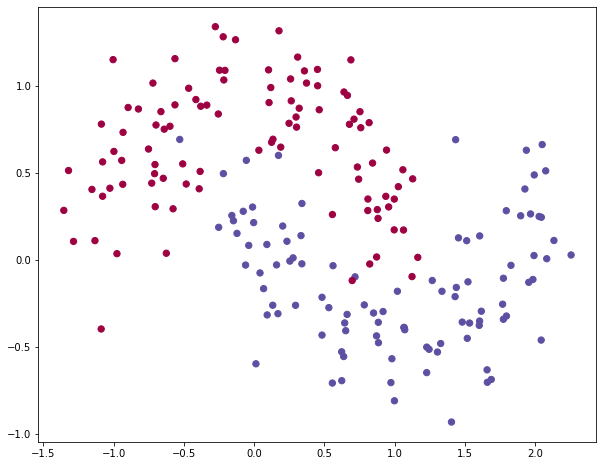

In [3]:
# Generate a dataset and plot it
np.random.seed(0)
train_X, train_y = sklearn.datasets.make_moons(200, noise=0.20)
train_X = train_X.astype(np.float32)
train_y = train_y.astype(np.int32)
plt.scatter(train_X[:,0], train_X[:,1], s=40
, c=train_y, cmap=plt.cm.Spectral)

In [4]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = train_X[:, 0].min() - .5, train_X[:, 0].max() + .5
    y_min, y_max = train_X[:, 1].min() - .5, train_X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=plt.cm.Spectral)

In [5]:
# Size definitions
num_examples = len(train_X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 3 # output layer dimensionality
nn_hdim = 100 # hiden layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength 

## Defining the Computation Graph in Theano

The first thing we need to is define our computations using Theano. We start by defining our input data matrix `X` and our training labels `y`:

In [6]:
# Our data vectors
X = T.matrix('X') # matrix of doubles
y = T.lvector('y') # vector of int64

Here's crucial thing to understand: We have not assigned any values to `X` or `y`. All we have done is defined mathematical expressions for them. We can use these expressions in subsequent calculations. If we want to evaluate an expression we can call its `eval` method. For example, to evaluate the expression `X * 2` for a given value of `X` we could do the following:

In [7]:
(X * 2).eval({X : [[1,1],[2,2]] })

array([[2., 2.],
       [4., 4.]])

Theano handles the type checking for us, which is very useful when defining more complex expressions. Trying to assign a value of the wrong data type to `X` would result in an error. [Here is the full list of Theano types](http://deeplearning.net/software/theano/library/tensor/basic.html#all-fully-typed-constructors).

`X` and `y` above are *stateless*. Whenever we want to evaluate an expression that depends on them we need to provide their values. Theano also has something called [shared variables](http://deeplearning.net/software/theano/tutorial/examples.html#using-shared-variables), which have internal state associated with them. Their value that is kept in memory and can be shared by all functions that use them. 

Shared variables can also be updated, and Theano includes low-level optimizations that makes updating them very efficient, especially on GPUs. Our network parameters $W_1, b_1, W_2, b_2$ are constantly updated using gradient descent, so they are perfect candidates for shared variables:

In [8]:
# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

Next, let's define expressions for our forward propagation. The calculations are identical to what we did in our [previous implementation](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/), just that we are defining Theano expressions. Again, remember that these expressions are not evaluated, we are just defining them. 

You can think of them as lambda expressions that require input values when called. We also use some of Theano's convenience functions like [nnet.softmax](http://deeplearning.net/software/theano/library/tensor/nnet/nnet.html#tensor.nnet.softmax) and [nnet.categorical_crossentropy](http://deeplearning.net/software/theano/library/tensor/nnet/nnet.html#tensor.nnet.categorical_crossentropy) replace our manual implementations:

In [9]:
# Forward propagation
# Note: We are just defining the expressions
# Nothing is evaluated here!
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2) # output probabilties

# The regularization term (optional)
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 

# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(y_hat, axis=1)

We saw how we can evaluate a Theano expression by calling its `eval` method. A much more convenient way is to create a [Theano function](http://deeplearning.net/software/theano/library/compile/function.html#function.function) for expressions we want to evaluate. To create a function we need to define its inputs and outputs. For example, to calculate the loss, we need to know the values for $X$ and $y$. Once created, we can call it function just like any other Python function.

In [10]:
# Theano functions that can be called from our Python code
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

# Example call: Forward Propagation
forward_prop([[1,2]])

array([[9.99734046e-01, 2.26472669e-04, 3.94809105e-05]])

Now is a good time to get a sense of how Theano constructs a computational graph. Looking at the expressions for $\hat{y}$, we can see that it depends on $z2$, which in turn depends on $a_1$, $W_2$ and $b_2$, and so on. Theano lets us visualize this:

<img src="theano rep.png" style="width:800px;height:900px;">


This is the *optimized* computational graph that Theano has constructed for our `forward_prop` function. We can also get a textual description:

In [11]:
theano.printing.debugprint(forward_prop)

SoftmaxWithBias [id A] ''   4
 |Dot22 [id B] ''   3
 | |Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)] [id C] ''   2
 | | |Dot22 [id D] ''   1
 | | | |X [id E]
 | | | |W1 [id F]
 | | |InplaceDimShuffle{x,0} [id G] ''   0
 | |   |b1 [id H]
 | |W2 [id I]
 |b2 [id J]


What's left is defining the updates to the network parameters we use with gradient descent. We previously calculated the gradients using backpropagation. We could express the same calculations using Theano (see code that's commented out below), but it's much easier if we let Theano calculate the derivatives for us! We need the derivates of our loss function $L$ with respect to our parameters: $\frac{\partial L}{\partial W_2}$, $\frac{\partial L}{\partial b_2}$, $\frac{\partial L}{\partial W_1}$, $\frac{\partial L}{\partial b_1}$:

In [12]:
# Easy: Let Theano calculate the derivatives for us!
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

# Backpropagation (Manual)
# Note: We are just defining the expressions, nothing is evaluated here!
# y_onehot = T.eye(2)[y]
# delta3 = y_hat - y_onehot
# dW2 = (a1.T).dot(delta3) * (1. + reg_lambda)
# db2 = T.sum(delta3, axis=0)
# delta2 = delta3.dot(W2.T) * (1. - T.sqr(a1))
# dW1 = T.dot(X.T, delta2) * (1 + reg_lambda)
# db1 = T.sum(delta2, axis=0)

Because we defined $W_2, b_2, W_1, b_1$ as shared variables we can use Theano's update mechanism to update their values. The following function (without return value) does a single gradient descent update given $X$ and $y$ as inputs:

In [13]:
gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

Note that we don't need to explicitly do a forward propagation here. Theano knows that our gradients depend on our predictions from the forward propagation and it will handle all the necessary calculations for us. It does everything it needs to update the values.

Let's now define a function to train a Neural Network using gradient descent. Again, it's equivalent to what we had in our original code, only that we are now calling the `gradient_step` function defined above instead of doing the calculations ourselves.

In [14]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(num_passes=20000, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print ("Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y)))

Loss after iteration 0: 1.292170
Loss after iteration 1000: 0.326494
Loss after iteration 2000: 0.290861
Loss after iteration 3000: 0.265470
Loss after iteration 4000: 0.241461
Loss after iteration 5000: 0.219004
Loss after iteration 6000: 0.199101
Loss after iteration 7000: 0.182162
Loss after iteration 8000: 0.168129
Loss after iteration 9000: 0.156675
Loss after iteration 10000: 0.147356
Loss after iteration 11000: 0.139731
Loss after iteration 12000: 0.133422
Loss after iteration 13000: 0.128129
Loss after iteration 14000: 0.123619
Loss after iteration 15000: 0.119719
Loss after iteration 16000: 0.116299
Loss after iteration 17000: 0.113259
Loss after iteration 18000: 0.110527
Loss after iteration 19000: 0.108045


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

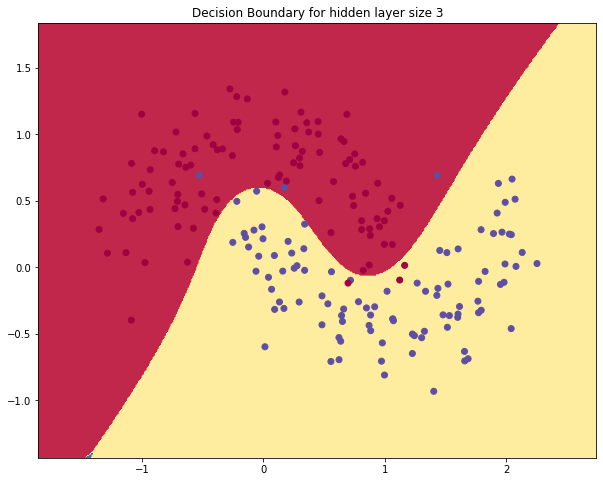

In [15]:
# Build a model with a 3-dimensional hidden layer
build_model(print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x))
plt.title("Decision Boundary for hidden layer size 3")

That's it! We've just ported our code over to Theano. I got a 2-3x speedup on my Macbook (it would likely be more if we had larger matrix multiplications). Note that we're not using a GPU yet. Let's do that next!